In [19]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# !pip install torchinfo
import torchinfo

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
#=======================Define masking function=======================#
class Mask(object):
    def __init__(self, masking_rate):
        self.masking_rate = masking_rate

    def __call__(self, matrix_3d):
        num_columns_to_mask = int(self.masking_rate * matrix_3d.shape[2])
        columns_to_mask = np.random.choice(matrix_3d.shape[2], num_columns_to_mask, replace=False)
        matrix_3d_mask = matrix_3d.clone()
        matrix_3d_mask[:,:, columns_to_mask] = 0
        return matrix_3d, matrix_3d_mask
        


In [21]:
#=======================Training parameters=======================#
bs = 64             # batch size
masking_rate = 0.5  # masking rate
lr = 0.0002         # learning rate
n_epoch = 10        # number of epoch

In [22]:
#=======================Create MNIST datasets=======================#
## create two transform (G has masked data and D has original data)
mask = Mask(masking_rate)
transform_d_g = transforms.Compose([transforms.ToTensor(),mask])

train_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=True, transform=transform_d_g, download=True)
train_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=True)

validation_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_d_g, download=False)
validation_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)

test_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_d_g, download=False)
test_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)


In [23]:
# #=======================Create F-MNIST datasets=======================#
# ## create two transform (G has masked data and D has original data)
# mask = Mask(masking_rate)
# transform_d_g = transforms.Compose([transforms.ToTensor(),mask])

# train_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=True, transform=transform_d_g, download=True)
# train_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=True)

# validation_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=False, transform=transform_d_g, download=False)
# validation_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)

# test_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=False, transform=transform_d_g, download=False)
# test_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)


In [24]:
#=======================Build GAN=======================#
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, 0.3) # force the network use different neurons
        x = torch.sigmoid(self.fc4(x))

        return x  #-1<x<1

class CNN_Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(CNN_Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #AutoML
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7,1024)  # Adjust the input size based on your input dimensions
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.dropout = nn.Dropout(0.3)  # Adjust the dropout rate as needed

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x


In [25]:
#=======================Build the network=======================#
z_dim = 28*28
mnist_dim = train_dataset_d_g.data.size(1) * train_dataset_d_g.data.size(2)

G = Generator(g_input_dim = mnist_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [26]:
#=======================Choose loss and optimizer=======================#
# loss
criterion = nn.BCELoss() # binary crossentropy loss, normalised ./. two classes
mse_loss = nn.MSELoss(reduce=True,reduction='sum')

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [27]:
def D_train(x_d,x_g):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    bs = x_d.shape[0]
    # x_d = torch.mean(x, dim = 1)
    x_real, y_real = x_d.view(-1, mnist_dim), torch.ones(bs, 1)  # assigning the input image with 1 (real)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    # D_output = D(x_d)
    D_output = D(x_real)
    # print(D_output.shape, y_real.shape, x_real.shape)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake
    z = x_g.view(-1, mnist_dim) ##!!
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device)) # assigning the input image with 0 (fake)

    # x_fake = x_fake.view(x_fake.size(0), 1, 28, 28)
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)  # probability compare with 0

    # gradient backprop & optimize ONLY D's parameters
    D_loss = (D_real_loss + D_fake_loss)/2
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [28]:
def D_val(x_d,x_g):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    bs = x_d.shape[0]
    # x_d = torch.mean(x, dim = 1)
    x_real, y_real = x_d.view(-1, mnist_dim), torch.ones(bs, 1)  # assigning the input image with 1 (real)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    # D_output = D(x_d)
    D_output = D(x_real)
    # print(D_output.shape, y_real.shape, x_real.shape)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake
    z = x_g.view(-1, mnist_dim) ##!!
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device)) # assigning the input image with 0 (fake)

    # x_fake = x_fake.view(x_fake.size(0), 1, 28, 28)
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)  # probability compare with 0

    D_loss = (D_real_loss + D_fake_loss)/2
        
    return  D_loss.data.item()

In [29]:
def G_train(x_d, x_g):
    #=======================Train the generator=======================#
    # print(x_g.shape)
    bs = x_g.shape[0]
    G.zero_grad()

    z = x_g.view(-1, mnist_dim)
    y = Variable(torch.ones(bs, 1).to(device))
    
    G_output = G(z)
    ##
    # G_output2 = G_output.view(G_output.size(0), 1, 28, 28)
    D_output = D(G_output)

    # Reshape the tensor
    x_d = x_d.view((x_d.size(0), -1))  # Keep the first dimension (batch size), flatten the rest
    G_loss = criterion(D_output, y) + mse_loss(G_output, x_d)
    # bce_loss = criterion(D_output, y)
    m_loss = mse_loss(G_output, x_d)
    
    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(), m_loss.data.item()

In [30]:
def G_val(x_d, x_g):
    #=======================Train the generator=======================#
    # print(x_g.shape)
    bs = x_g.shape[0]
    G.zero_grad()

    z = x_g.view(-1, mnist_dim)
    y = Variable(torch.ones(bs, 1).to(device))
    
    G_output = G(z)
    ##
    # G_output2 = G_output.view(G_output.size(0), 1, 28, 28)
    D_output = D(G_output)

    # Reshape the tensor
    x_d = x_d.view((x_d.size(0), -1))  # Keep the first dimension (batch size), flatten the rest
    G_loss = criterion(D_output, y) + mse_loss(G_output, x_d)
    # bce_loss = criterion(D_output, y)
    m_loss = mse_loss(G_output, x_d)

    return G_loss.data.item(), m_loss.data.item()

In [31]:
# #===================Train the model===================#
# for epoch in range(1, n_epoch+1):     
#     # print(next(iter(train_loader)))   
#     D_losses,G_losses, mse_losses = [],[],[]

#     for batch_idx,(((x_d, x_g), _)) in enumerate(tqdm(train_loader_d_g)):
#         G_losses.append(G_train(x_d, x_g)[0])
#         D_losses.append(D_train(x_d, x_g))
#         mse_losses.append(G_train(x_d, x_g)[1])

#         # plot data
#         if batch_idx == len(train_loader_d_g)-1:
#             data = x_g[0][0]
#             original = x_d[0][0]
#             z = data.view(-1, mnist_dim)
#             fig, ax = plt.subplots(1,3)
#             ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
#             ax[1].imshow(G(z).detach().numpy().reshape(28,28), cmap='Greys')
#             ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
#             plt.show()
#         # break

        
#     print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, loss_mse: %.3f' % (
#             (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses)), torch.mean(torch.FloatTensor(mse_losses))))


In [32]:
#===================Train the model===================#
D_loss_train = []
D_loss_val = []
G_loss_train = []
G_loss_val = []
m_loss_train = []
m_loss_val = []

for epoch in range(1, n_epoch+1):     
    # print(next(iter(train_loader)))   
    D_losses,G_losses, mse_losses = [],[],[]

    for batch_idx,(((x_d, x_g), _)) in enumerate(train_loader_d_g):
        x_d=x_d.to(device)
        x_g=x_g.to(device)  
        gen_loss_first, mse_loss_first = G_train(x_d, x_g)
        D_losses.append(D_train(x_d, x_g))
        gen_loss_second, mse_loss_second = G_train(x_d, x_g)
        G_losses.append((gen_loss_second + gen_loss_first)/2)
        mse_losses.append((mse_loss_second + mse_loss_first)/2)
        
        # plot data
        # if batch_idx == len(train_loader_d_g)-1:
        #     data = x_g[0][0]
        #     original = x_d[0][0]
        #     z = data.view(-1, mnist_dim)
        #     fig, ax = plt.subplots(1,3)
        #     ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
        #     ax[1].imshow(G(z).cpu().detach().numpy().reshape(28,28), cmap='Greys')
        #     ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
        #     plt.show()
        # break

    D_loss_train.append(torch.mean(torch.FloatTensor(D_losses)).item())
    G_loss_train.append(torch.mean(torch.FloatTensor(G_losses)).item())
    m_loss_train.append(torch.mean(torch.FloatTensor(mse_losses)).item())

    print('Training [%d/%d]: loss_d: %.5f, loss_g: %.5f, loss_mse: %.5f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses)), torch.mean(torch.FloatTensor(mse_losses))))
    
    # validation
    D_losses,G_losses, mse_losses = [],[],[]
    for batch_idx,(((x_d, x_g), _)) in enumerate(test_loader_d_g):
        x_d=x_d.to(device)
        x_g=x_g.to(device)
        G_losses.append(G_val(x_d, x_g)[0])
        D_losses.append(D_val(x_d, x_g))
        mse_losses.append(G_val(x_d, x_g)[1])
    
    D_loss_val.append(torch.mean(torch.FloatTensor(D_losses)).item())
    G_loss_val.append(torch.mean(torch.FloatTensor(G_losses)).item())
    m_loss_val.append(torch.mean(torch.FloatTensor(mse_losses)).item())
        
    print('Validation [%d/%d]: loss_d: %.5f, loss_g: %.5f, loss_mse: %.5f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses)), torch.mean(torch.FloatTensor(mse_losses))))


Training [1/10]: loss_d: 0.69596, loss_g: 0.89239, loss_mse: 0.10780
Validation [1/10]: loss_d: 0.62340, loss_g: 0.98929, loss_mse: 0.11143
Training [2/10]: loss_d: 0.69375, loss_g: 0.85391, loss_mse: 0.09724
Validation [2/10]: loss_d: 0.68821, loss_g: 0.76498, loss_mse: 0.07881
Training [3/10]: loss_d: 0.69338, loss_g: 0.74560, loss_mse: 0.05166
Validation [3/10]: loss_d: 0.69280, loss_g: 0.73769, loss_mse: 0.04282
Training [4/10]: loss_d: 0.69309, loss_g: 0.73168, loss_mse: 0.03851
Validation [4/10]: loss_d: 0.69276, loss_g: 0.72734, loss_mse: 0.03394
Training [5/10]: loss_d: 0.69306, loss_g: 0.72456, loss_mse: 0.03213
Validation [5/10]: loss_d: 0.69291, loss_g: 0.72281, loss_mse: 0.02965
Training [6/10]: loss_d: 0.69310, loss_g: 0.72101, loss_mse: 0.02843
Validation [6/10]: loss_d: 0.69282, loss_g: 0.72263, loss_mse: 0.02635
Training [7/10]: loss_d: 0.69313, loss_g: 0.71985, loss_mse: 0.02595
Validation [7/10]: loss_d: 0.69291, loss_g: 0.72055, loss_mse: 0.02492
Training [8/10]: los

In [33]:
loss_dict = {'D_loss_train': D_loss_train,
'D_loss_val': D_loss_val,
'G_loss_train': G_loss_train,
'G_loss_val': G_loss_val,
'm_loss_train': m_loss_train,
'm_loss_val': m_loss_val}

print(loss_dict)

{'D_loss_train': [0.6959559321403503, 0.6937533617019653, 0.6933814883232117, 0.6930937767028809, 0.6930562257766724, 0.6931020021438599, 0.6931285858154297, 0.6931386590003967, 0.6931332349777222, 0.6930601000785828], 'D_loss_val': [0.6233959197998047, 0.6882113814353943, 0.6927973031997681, 0.6927571296691895, 0.6929111480712891, 0.6928166151046753, 0.6929084658622742, 0.6932144165039062, 0.6926721334457397, 0.6925209760665894], 'G_loss_train': [0.8923910856246948, 0.8539129495620728, 0.7456011772155762, 0.7316796779632568, 0.7245588302612305, 0.7210081219673157, 0.7198490500450134, 0.7178289294242859, 0.7165964245796204, 0.7161259651184082], 'G_loss_val': [0.9892879128456116, 0.7649821639060974, 0.7376859188079834, 0.7273378968238831, 0.7228130102157593, 0.7226331233978271, 0.7205546498298645, 0.7217980623245239, 0.715857207775116, 0.7165733575820923], 'm_loss_train': [0.10779856890439987, 0.09723976254463196, 0.05165832117199898, 0.0385112464427948, 0.03213122487068176, 0.028434135

In [37]:
# #===================Test the model===================#
# index = 28

# for batch_idx,(((x_d, x_g), _)) in enumerate(test_loader_d_g):
#     if batch_idx == index:
#         data = x_g[0][0]
#         original = x_d[0][0]
#         z = data.view(-1, mnist_dim)

#         fig, ax = plt.subplots(1,3)
#         ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
#         ax[1].imshow(G(z).detach().numpy().reshape(28,28), cmap='Greys')
#         ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
#         plt.show()

#         break

In [38]:
data=torch.load('sample_pics/mask_seven.pth')
original=torch.load('sample_pics/og_seven.pth')

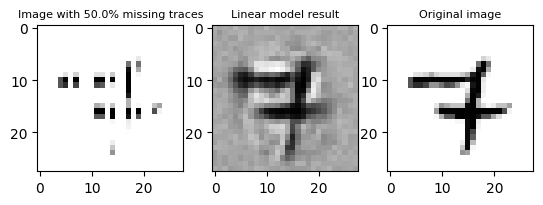

In [39]:

z = data.view(-1, mnist_dim)

fig, ax = plt.subplots(1,3)
ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
ax[0].set_title(f'Image with {masking_rate*100}% missing traces',size=8)
ax[1].imshow(G(z).detach().numpy().reshape(28,28), cmap='Greys')
ax[1].set_title(f'Linear model result',size=8)
ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
ax[2].set_title(f'Original image',size=8)

plt.show()

In [45]:
# #===================Visualise the feature map===================#
# ## ref: https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
# ## ref: https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
# import random
# index = 7
# model_children = list(G.children())
# print(model_children)

# for batch_idx,(((x_d, x_g), _)) in enumerate(validation_loader_d_g):
#     x_d=x_d.to(device)
#     x_g=x_g.to(device)

#     if batch_idx == index:
#         data = x_g[0][0]
#         original = x_d[0][0]
#         z = data.view(-1, mnist_dim)

#         fig, ax = plt.subplots(1,3)
#         ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
#         ax[0].set_title(f'Image with {masking_rate*100}% missing traces',size=8)
#         ax[1].imshow(G(z).cpu().detach().numpy().reshape(28,28), cmap='Greys')
#         ax[1].set_title(f'Reconstructed image',size=8)
#         ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
#         ax[2].set_title(f'Original image',size=8)

#         fig = plt.figure(figsize=(30, 35))
#         image = x_g
#         tensor_dict = {}
#         layer = 0
        
#         for count,layer in enumerate(model_children[:]):
#             name = str(layer)
#             name = name.split("(")[0]

#             image = layer(image)

#             # save the output tensor of each layer
#             tensor_dict[count] = image

#             # plotting params
#             channel = image.shape[1]
#             size = image.shape[2]
#             elem_per_row = 12
#             target_width = elem_per_row * 28

#             a = fig.add_subplot(4, 1, count+1)

#             images = []
#             used = set()
#             for i in range(min(target_width // size , channel)):
#                 new_ind = random.randint(0, channel - 1)
#                 while new_ind in used:
#                     new_ind = random.randint(0, channel - 1)
#                 used.add(new_ind)
#                 images.append(image[0][new_ind].reshape(size,size))

#             # create image belt
#             combined_image = torch.hstack(images)

#             imgplot = plt.imshow(combined_image.cpu().detach().numpy(), cmap='Greys')
#             imgplot = plt.axis('off')
#             a.set_title(f'{name} {image.shape}', fontsize=20)

#         break